# 1: Data Pre-Processing

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import patches as mpatches
from matplotlib.ticker import MultipleLocator
import matplotlib.ticker as tck
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
import re
import sys
import seaborn as sns
from itertools import product
from scipy import stats
from scipy.stats import pearsonr
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,r2_score, mean_squared_error
from sklearn.metrics import RocCurveDisplay, roc_auc_score
from sklearn.linear_model import RidgeCV
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay,classification_report
from sklearn.svm import SVC, SVR
from sklearn.preprocessing import LabelEncoder, label_binarize, StandardScaler
import GEOparse
from rdkit.Chem import AllChem

In [2]:
#took from this link https://www.blopig.com/blog/2022/11/how-to-turn-a-smiles-string-into-an-extended-connectivity-fingerprint-using-rdkit/
def ECFP_from_smiles(smiles,
                     R = 2,
                     L = 2**10,
                     use_features = False,
                     use_chirality = False):
    """
    Inputs:
    
    - smiles ... SMILES string of input compound
    - R ... maximum radius of circular substructures
    - L ... fingerprint-length
    - use_features ... if false then use standard DAYLIGHT atom features, if true then use pharmacophoric atom features
    - use_chirality ... if true then append tetrahedral chirality flags to atom features
    
    Outputs:
    - np.array(feature_list) ... ECFP with length L and maximum radius R
    """
    
    molecule = AllChem.MolFromSmiles(smiles)
    feature_list = AllChem.GetMorganFingerprintAsBitVect(molecule,
                                                                       radius = R,
                                                                       nBits = L,
                                                                       useFeatures = use_features,
                                                                       useChirality = use_chirality)
    return np.array(feature_list)

## a. load the _train.csv_ datafile provided
## NOTE: the provided _test.csv_ has not been loaded yet

In [3]:
#load the train.csv data provided
training_df = pd.read_csv('train.csv')
training_df

,SMILES,Lab,RT
0,CCCCCn1nc(C(=O)NC(C(=O)OCC)C(C)(C)C)c2ccccc21,Aarhus,8.53
1,COc1ccc2[nH]cc(CCN(C(C)C)C(C)C)c2c1,Aarhus,4.45
2,C=CCCCn1nc(C(=O)NC(C(=O)OC)C(C)(C)C)c2ccccc21,Aarhus,7.97
3,CC=CC(=O)N(c1ccccc1)C1CCN(CCc2ccccc2)CC1,Aarhus,5.29
4,CC1COC(c2ccccc2)CN1,Aarhus,2.68
...,...,...,...
3771,CCCCCn1nc(C(=O)NC(C)(C)c2ccccc2)c2ccccc21,Zurich Institute of Forensic Medicine,12.43
3772,CCCCC(C(=O)c1ccc(C)cc1)N1CCCC1,Zurich Institute of Forensic Medicine,6.12
3773,CCN(CC)CCn1c(Cc2ccc(OC(C)C)cc2)nc2cc([N+](=O)[...,Zurich Institute of Forensic Medicine,7.72
3774,CCC1C(C)=NN=C(c2ccc(OC)c(OC)c2)c2cc(OC)c(OC)cc21,Zurich Institute of Forensic Medicine,8.10


## b. Compute Extended Connectivity Fingerprint (ECFP) using the _ECFP_from_smiles_ function provided above

In [4]:
feature_space = np.zeros(shape=(training_df.shape[0],1024))
j=0
for smilestring in training_df['SMILES'].values:
    ecfp_val=ECFP_from_smiles(smilestring,
                     R = 2,
                     L = 2**10,
                     use_features = False,
                     use_chirality = False)
    feature_space[j] = ecfp_val
    j+=1
training_df_ECFP = pd.concat([training_df,pd.DataFrame(feature_space,columns=[f'feat_ECFP_{i}' for i in np.arange(0,feature_space.shape[1],1) ])],axis=1).copy()
training_df_ECFP

,SMILES,Lab,RT,feat_ECFP_0,feat_ECFP_1,feat_ECFP_2,feat_ECFP_3,feat_ECFP_4,feat_ECFP_5,feat_ECFP_6,...,feat_ECFP_1014,feat_ECFP_1015,feat_ECFP_1016,feat_ECFP_1017,feat_ECFP_1018,feat_ECFP_1019,feat_ECFP_1020,feat_ECFP_1021,feat_ECFP_1022,feat_ECFP_1023
0,CCCCCn1nc(C(=O)NC(C(=O)OCC)C(C)(C)C)c2ccccc21,Aarhus,8.53,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,COc1ccc2[nH]cc(CCN(C(C)C)C(C)C)c2c1,Aarhus,4.45,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,C=CCCCn1nc(C(=O)NC(C(=O)OC)C(C)(C)C)c2ccccc21,Aarhus,7.97,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CC=CC(=O)N(c1ccccc1)C1CCN(CCc2ccccc2)CC1,Aarhus,5.29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,CC1COC(c2ccccc2)CN1,Aarhus,2.68,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3771,CCCCCn1nc(C(=O)NC(C)(C)c2ccccc2)c2ccccc21,Zurich Institute of Forensic Medicine,12.43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3772,CCCCC(C(=O)c1ccc(C)cc1)N1CCCC1,Zurich Institute of Forensic Medicine,6.12,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3773,CCN(CC)CCn1c(Cc2ccc(OC(C)C)cc2)nc2cc([N+](=O)[...,Zurich Institute of Forensic Medicine,7.72,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3774,CCC1C(C)=NN=C(c2ccc(OC)c(OC)c2)c2cc(OC)c(OC)cc21,Zurich Institute of Forensic Medicine,8.10,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


## c. One-hot encode the categorical 'Lab' column

In [5]:
lab_onehotencoded = pd.get_dummies(training_df['Lab'],dtype='float').copy()
lab_onehotencoded

,Aarhus,Academy of Forensic Science,Adelaide,Australian Racing Forensic Laboratory,CFSRE,ChemCentre,Copenhagen,Estonian Forensic Science Institute,Finnish Customs Laboratory,Ghent University,...,Labor Krone,Mainz,Odense,San Francisco OCME,The University of Queensland,Trondheim,University Hospital of Northern Norway,University of Athens,Victorian Institute of Forensic Medicine,Zurich Institute of Forensic Medicine
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3771,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3772,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3773,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3774,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## d. Separate out features (X) and labels (y) and check for missing values

In [6]:
X = pd.concat([lab_onehotencoded,training_df_ECFP[training_df_ECFP.columns[training_df_ECFP.columns.str.contains('feat')].to_list()]],axis=1)

In [7]:
y = training_df['RT']

In [8]:
X[X.isnull()].sum().sum()

0.0

In [9]:
y[y.isnull()].sum().sum()

0.0

In [10]:
del training_df,lab_onehotencoded

# 2. Run Some Regressor Models 

## a. Random Forest Regressor (scikit-learn)

In [11]:
# adapted from this website: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

labels = np.array(y)
features= np.array(X)

### Note: train-test-split with a fixed seed here

In [12]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [13]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)


Training Features Shape: (2832, 1047)
Training Labels Shape: (2832,)
Testing Features Shape: (944, 1047)
Testing Labels Shape: (944,)


In [14]:

from sklearn.ensemble import RandomForestRegressor
chosen_model=RandomForestRegressor(n_estimators = 1000, random_state = 42)
rf = chosen_model

rf.fit(train_features, train_labels);


In [15]:

predictions = rf.predict(test_features)
# Calculate the errors
errors = predictions - test_labels
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(abs(errors)), 2))
print('MSE:', round(mean_squared_error(test_labels,predictions),2))

Mean Absolute Error: 0.71
MSE: 1.26


### ONLY for the random forest model, examine the feature importance list. Double-check that the model is using both 'Lab' information and ECFP information from the chemical structure as features. Examine the top 500,1000 features. 

In [16]:
#get feature importance from model
feature_importances={"feature": [],"importance": []}
for i,j in zip(X.columns,rf.feature_importances_):
        feature_importances['feature'].append(i) 
        feature_importances['importance'].append(j)

In [17]:
#convert to dataframe. Sort by importance. Add a category that classifies features as 'Lab' or 'ECFP'
feature_importances = pd.DataFrame(feature_importances).sort_values(by='importance',ascending=False).copy()
feature_importances['feature_category'] = ['ECFP' if 'feat' in feature else 'Lab' for feature in feature_importances.feature.values]
feature_importances = feature_importances.reset_index(drop=True).copy()

In [18]:
#what the dataframe looks like
feature_importances

,feature,importance,feature_category
0,feat_ECFP_549,0.345628,ECFP
1,Mainz,0.277239,Lab
2,Victorian Institute of Forensic Medicine,0.038393,Lab
3,feat_ECFP_935,0.032139,ECFP
4,feat_ECFP_420,0.015095,ECFP
...,...,...,...
1042,feat_ECFP_229,0.000000,ECFP
1043,feat_ECFP_376,0.000000,ECFP
1044,feat_ECFP_920,0.000000,ECFP
1045,feat_ECFP_16,0.000000,ECFP


In [19]:
#top 500 features
feature_importances.loc[:500]['feature_category'].value_counts()

feature_category
ECFP    478
Lab      23
Name: count, dtype: int64

In [20]:
#top 1000 features
feature_importances.loc[:1000]['feature_category'].value_counts()

feature_category
ECFP    978
Lab      23
Name: count, dtype: int64

### predicted vs actual for the test dataset

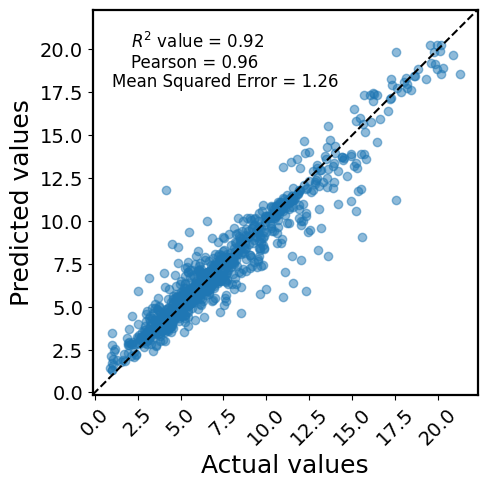

In [21]:
fig, ax = plt.subplots(figsize=(6,5))

true_val,pred_val = test_labels,predictions
ax.scatter(true_val,pred_val,alpha=0.5)



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.text(0.1,
                   0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                   transform=ax.transAxes,fontsize=12)

ax.text(0.1,
                   0.85,f'Pearson = {format(pearsonr(true_val, pred_val)[0],"0.2f")}',
                   transform=ax.transAxes,fontsize=12)
ax.text(0.05,
                   0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                   transform=ax.transAxes,fontsize=12)


# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Actual values',fontsize=18)
ax.set_ylabel('Predicted values',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
del true_val, pred_val

### double-check what predicted vs actual looks for the train dataset

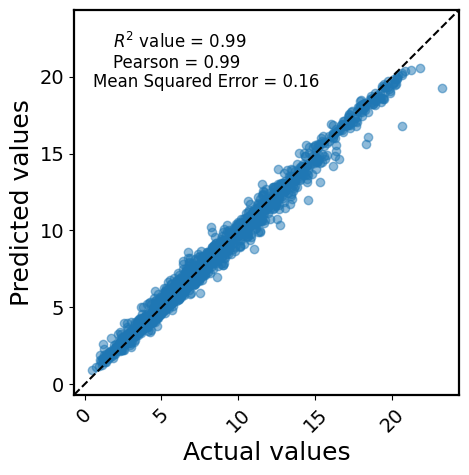

In [22]:
fig, ax = plt.subplots(figsize=(6,5))

true_val,pred_val = train_labels,rf.predict(train_features)
ax.scatter(true_val,pred_val,alpha=0.5)



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.text(0.1,
                   0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                   transform=ax.transAxes,fontsize=12)

ax.text(0.1,
                   0.85,f'Pearson = {format(pearsonr(true_val,pred_val)[0],"0.2f")}',
                   transform=ax.transAxes,fontsize=12)
ax.text(0.05,
                   0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                   transform=ax.transAxes,fontsize=12)


# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Actual values',fontsize=18)
ax.set_ylabel('Predicted values',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
del true_val, pred_val

### Residuals (only for test dataset) 

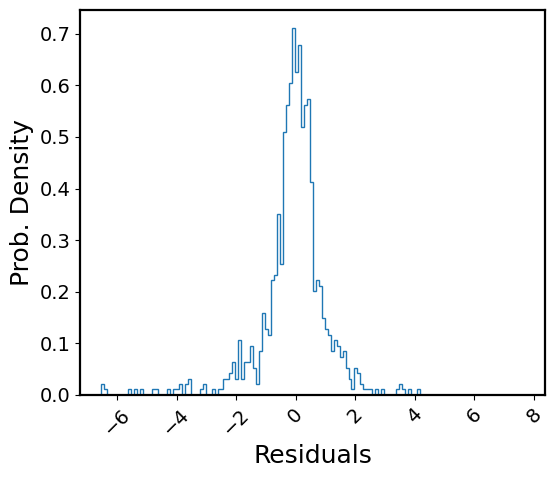

In [23]:
fig, ax = plt.subplots(figsize=(6,5))
ax.hist(errors,bins=np.arange(np.min(errors),np.max(errors),0.1),histtype='step',density=True,linewidth=1)
plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Residuals',fontsize=18)
ax.set_ylabel('Prob. Density',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)



In [24]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (abs(errors) / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 88.03 %.


In [25]:
del labels, features, mape, accuracy, predictions, errors,train_features, test_features, train_labels, test_labels, rf

### Now - running the model 6 times (each time with a random train-test split)

CPU times: user 7min 1s, sys: 445 ms, total: 7min 1s
Wall time: 7min 2s


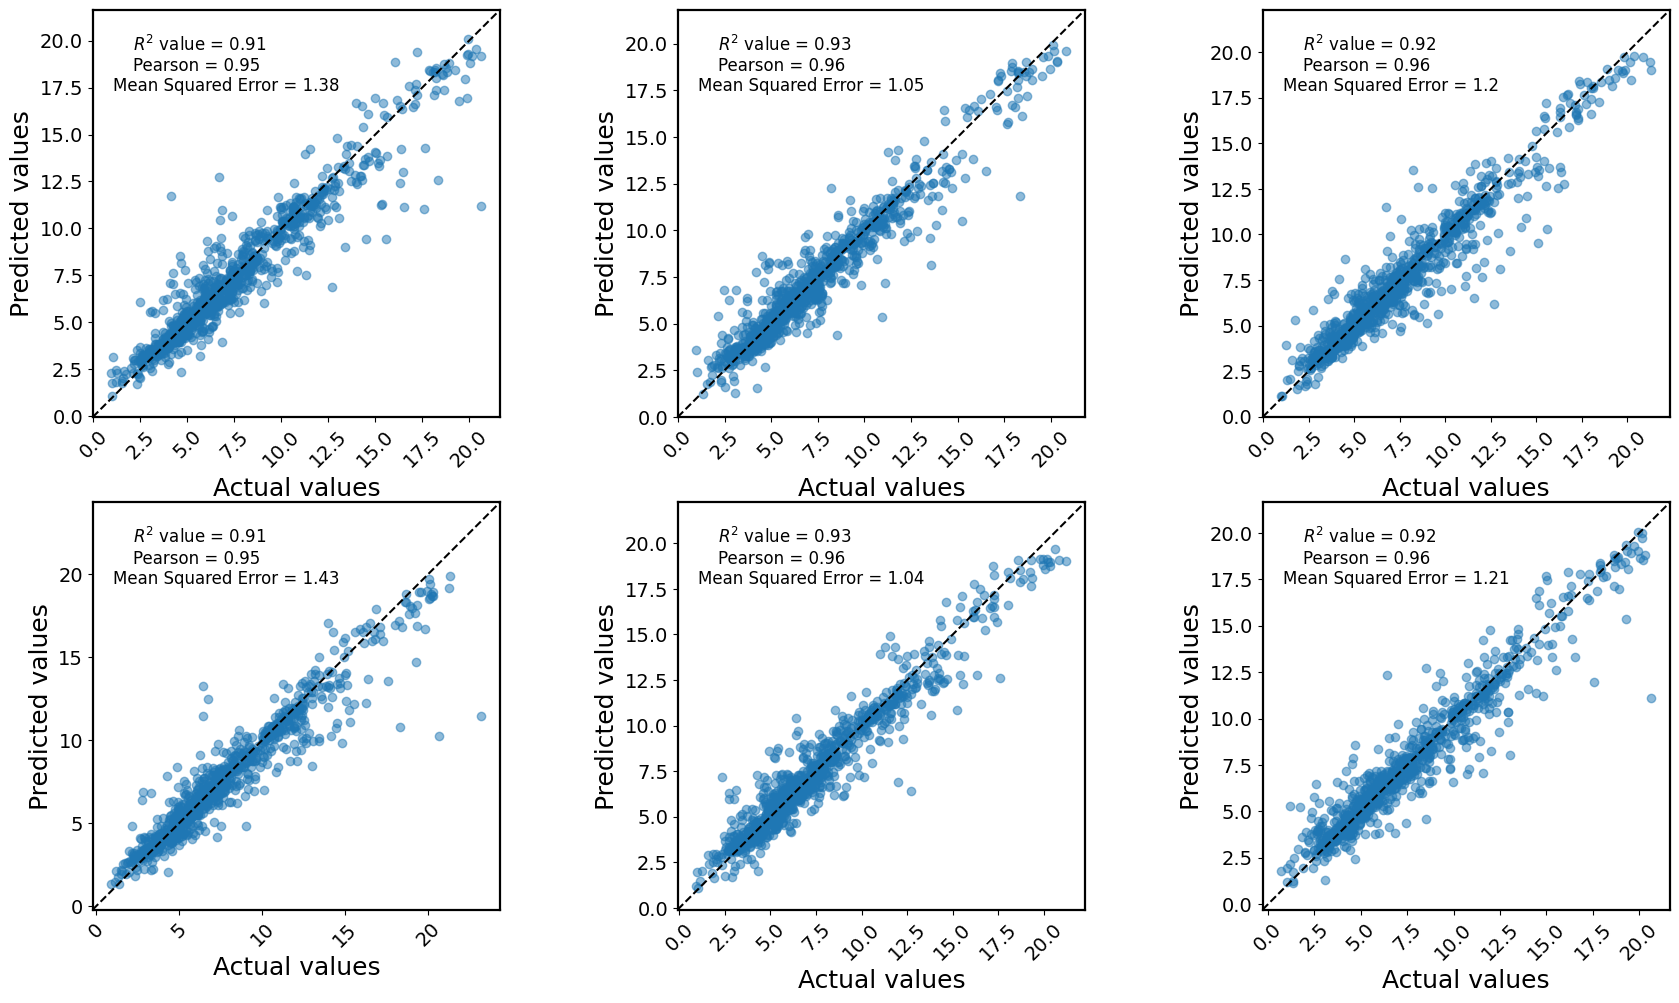

In [26]:
%%time
fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(18,10))
n = 6
for i,ax in zip(range(n),axs.ravel()):
    features= np.array(X)
    labels = np.array(y)
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = i)    
    rf = chosen_model
    rf.fit(train_features, train_labels);
    predictions = rf.predict(test_features)
    errors = predictions - test_labels
    
    #Generate plot
    
    true_val,pred_val = test_labels,predictions
    ax.scatter(true_val,pred_val,alpha=0.5)
    
    
    
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    ax.text(0.1,
                       0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                       transform=ax.transAxes,fontsize=12)
    
    ax.text(0.1,
                       0.85,f'Pearson = {format(pearsonr(true_val,pred_val)[0],"0.2f")}',
                       transform=ax.transAxes,fontsize=12)
    ax.text(0.05,
                       0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                       transform=ax.transAxes,fontsize=12)
    
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
    plt.setp(ax.get_yticklabels(),fontsize=14)
    ax.set_xlabel('Actual values',fontsize=18)
    ax.set_ylabel('Predicted values',fontsize=18)
    
    for i in ['top', 'left', 'right', 'bottom']:
            ax.spines[i].set_linewidth(1.6)
    del true_val, pred_val

plt.tight_layout()

In [27]:
del chosen_model, labels, features, train_features, test_features, train_labels, test_labels, rf, predictions, errors

## b. Gradient boost Regressor (scikit-learn)

In [28]:
# adapted from this website: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

labels = np.array(y)
features= np.array(X)

### Note: train-test-split with a fixed seed here

In [29]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [30]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)


Training Features Shape: (2832, 1047)
Training Labels Shape: (2832,)
Testing Features Shape: (944, 1047)
Testing Labels Shape: (944,)


In [31]:

from sklearn.ensemble import GradientBoostingRegressor
chosen_model=GradientBoostingRegressor(n_estimators = 1000, random_state = 42)
rf = chosen_model

rf.fit(train_features, train_labels);


In [32]:

predictions = rf.predict(test_features)
# Calculate the errors
errors = predictions - test_labels
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(abs(errors)), 2))
print('MSE:', round(mean_squared_error(test_labels,predictions),2))

Mean Absolute Error: 0.67
MSE: 1.03


### predicted vs actual for the test dataset

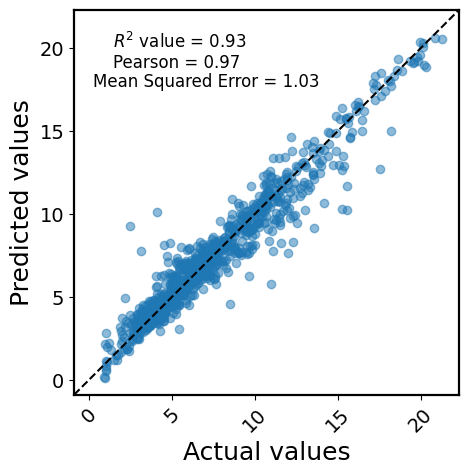

In [33]:
fig, ax = plt.subplots(figsize=(6,5))

true_val,pred_val = test_labels,predictions
ax.scatter(true_val,pred_val,alpha=0.5)



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.text(0.1,
                   0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                   transform=ax.transAxes,fontsize=12)

ax.text(0.1,
                   0.85,f'Pearson = {format(pearsonr(true_val, pred_val)[0],"0.2f")}',
                   transform=ax.transAxes,fontsize=12)
ax.text(0.05,
                   0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                   transform=ax.transAxes,fontsize=12)


# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Actual values',fontsize=18)
ax.set_ylabel('Predicted values',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
del true_val, pred_val

### double-check what predicted vs actual looks for the train dataset

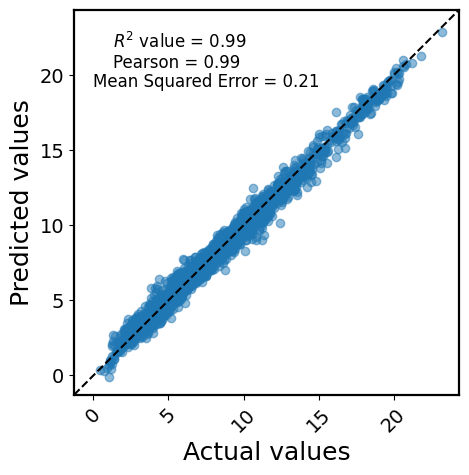

In [34]:
fig, ax = plt.subplots(figsize=(6,5))

true_val,pred_val = train_labels,rf.predict(train_features)
ax.scatter(true_val,pred_val,alpha=0.5)



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.text(0.1,
                   0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                   transform=ax.transAxes,fontsize=12)

ax.text(0.1,
                   0.85,f'Pearson = {format(pearsonr(true_val,pred_val)[0],"0.2f")}',
                   transform=ax.transAxes,fontsize=12)
ax.text(0.05,
                   0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                   transform=ax.transAxes,fontsize=12)


# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Actual values',fontsize=18)
ax.set_ylabel('Predicted values',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
del true_val, pred_val

### Residuals (only for test dataset) 

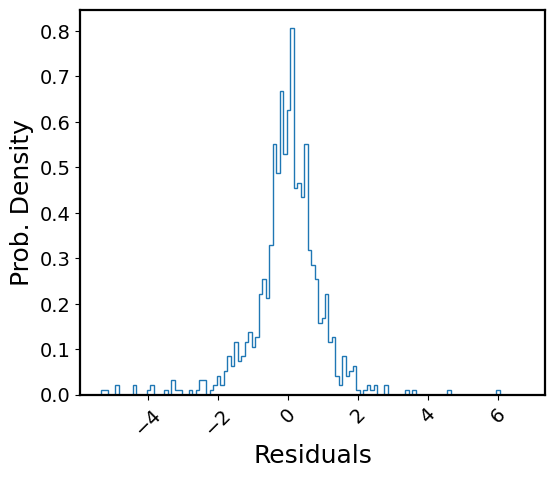

In [35]:
fig, ax = plt.subplots(figsize=(6,5))
ax.hist(errors,bins=np.arange(np.min(errors),np.max(errors),0.1),histtype='step',density=True,linewidth=1)
plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Residuals',fontsize=18)
ax.set_ylabel('Prob. Density',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)



In [36]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (abs(errors) / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 88.7 %.


In [37]:
del labels, features, mape, accuracy, predictions, errors,train_features, test_features, train_labels, test_labels, rf

### Now - running the model 6 times (each time with a random train-test split)

CPU times: user 2min 12s, sys: 295 ms, total: 2min 12s
Wall time: 2min 12s


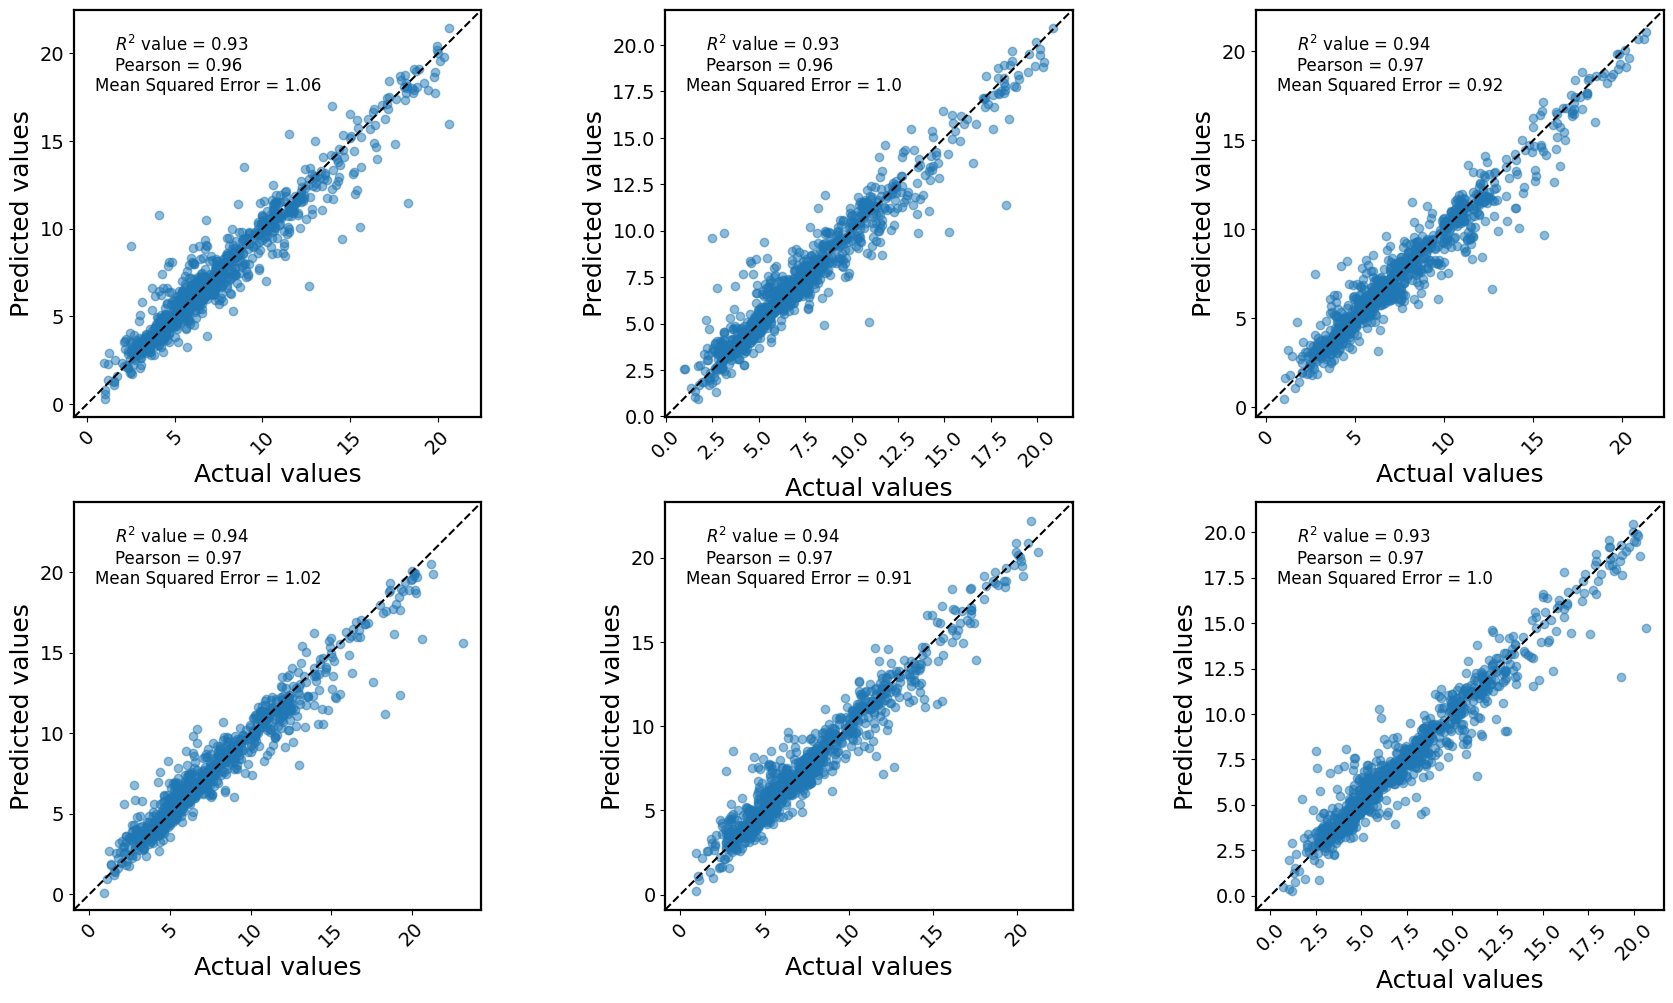

In [38]:
%%time
fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(18,10))
n = 6
for i,ax in zip(range(n),axs.ravel()):
    features= np.array(X)
    labels = np.array(y)
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = i)    
    rf = chosen_model
    rf.fit(train_features, train_labels);
    predictions = rf.predict(test_features)
    errors = predictions - test_labels
    
    #Generate plot
    
    true_val,pred_val = test_labels,predictions
    ax.scatter(true_val,pred_val,alpha=0.5)
    
    
    
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    ax.text(0.1,
                       0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                       transform=ax.transAxes,fontsize=12)
    
    ax.text(0.1,
                       0.85,f'Pearson = {format(pearsonr(true_val,pred_val)[0],"0.2f")}',
                       transform=ax.transAxes,fontsize=12)
    ax.text(0.05,
                       0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                       transform=ax.transAxes,fontsize=12)
    
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
    plt.setp(ax.get_yticklabels(),fontsize=14)
    ax.set_xlabel('Actual values',fontsize=18)
    ax.set_ylabel('Predicted values',fontsize=18)
    
    for i in ['top', 'left', 'right', 'bottom']:
            ax.spines[i].set_linewidth(1.6)
    del true_val, pred_val

plt.tight_layout()

In [39]:
del chosen_model, labels, features, train_features, test_features, train_labels, test_labels, rf, predictions, errors

## c. Support Vector Regressor (scikit-learn)

In [40]:
# adapted from this website: https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

labels = np.array(y)
features= np.array(X)

### Note: train-test-split with a fixed seed here

In [41]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [42]:
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)


Training Features Shape: (2832, 1047)
Training Labels Shape: (2832,)
Testing Features Shape: (944, 1047)
Testing Labels Shape: (944,)


In [43]:


chosen_model=SVR(kernel='rbf')
rf = chosen_model

rf.fit(train_features, train_labels);


In [44]:

predictions = rf.predict(test_features)
# Calculate the errors
errors = predictions - test_labels
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(abs(errors)), 2))
print('MSE:', round(mean_squared_error(test_labels,predictions),2))

Mean Absolute Error: 1.11
MSE: 2.94


### predicted vs actual for the test dataset

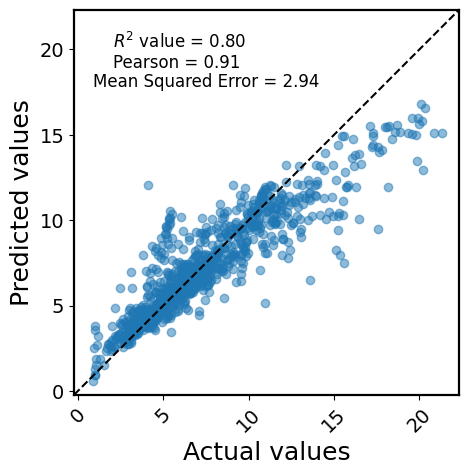

In [45]:
fig, ax = plt.subplots(figsize=(6,5))

true_val,pred_val = test_labels,predictions
ax.scatter(true_val,pred_val,alpha=0.5)



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.text(0.1,
                   0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                   transform=ax.transAxes,fontsize=12)

ax.text(0.1,
                   0.85,f'Pearson = {format(pearsonr(true_val, pred_val)[0],"0.2f")}',
                   transform=ax.transAxes,fontsize=12)
ax.text(0.05,
                   0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                   transform=ax.transAxes,fontsize=12)


# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Actual values',fontsize=18)
ax.set_ylabel('Predicted values',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
del true_val, pred_val

### check what predicted vs actual looks for the train dataset

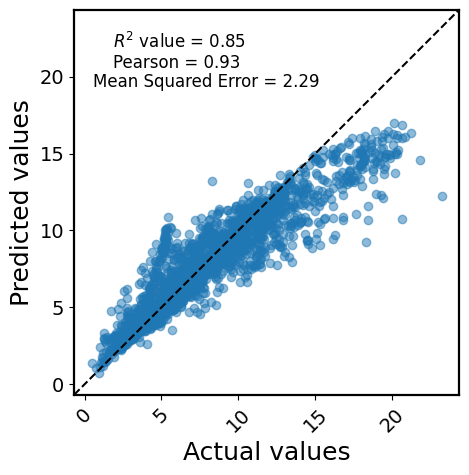

In [46]:
fig, ax = plt.subplots(figsize=(6,5))

true_val,pred_val = train_labels,rf.predict(train_features)
ax.scatter(true_val,pred_val,alpha=0.5)



lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
]

ax.text(0.1,
                   0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                   transform=ax.transAxes,fontsize=12)

ax.text(0.1,
                   0.85,f'Pearson = {format(pearsonr(true_val,pred_val)[0],"0.2f")}',
                   transform=ax.transAxes,fontsize=12)
ax.text(0.05,
                   0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                   transform=ax.transAxes,fontsize=12)


# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
ax.set_aspect('equal')
ax.set_xlim(lims)
ax.set_ylim(lims)

plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Actual values',fontsize=18)
ax.set_ylabel('Predicted values',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)
del true_val, pred_val

### Residuals (only for test dataset) 

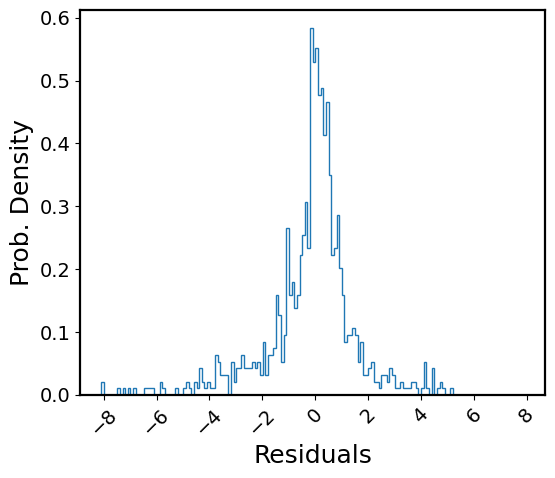

In [47]:
fig, ax = plt.subplots(figsize=(6,5))
ax.hist(errors,bins=np.arange(np.min(errors),np.max(errors),0.1),histtype='step',density=True,linewidth=1)
plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
plt.setp(ax.get_yticklabels(),fontsize=14)
ax.set_xlabel('Residuals',fontsize=18)
ax.set_ylabel('Prob. Density',fontsize=18)

for i in ['top', 'left', 'right', 'bottom']:
        ax.spines[i].set_linewidth(1.6)



In [48]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (abs(errors) / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

Accuracy: 83.11 %.


In [49]:
del labels, features, mape, accuracy, predictions, errors,train_features, test_features, train_labels, test_labels, rf

### Now - running the model 6 times (each time with a random train-test split)

CPU times: user 16.8 s, sys: 260 ms, total: 17 s
Wall time: 16.8 s


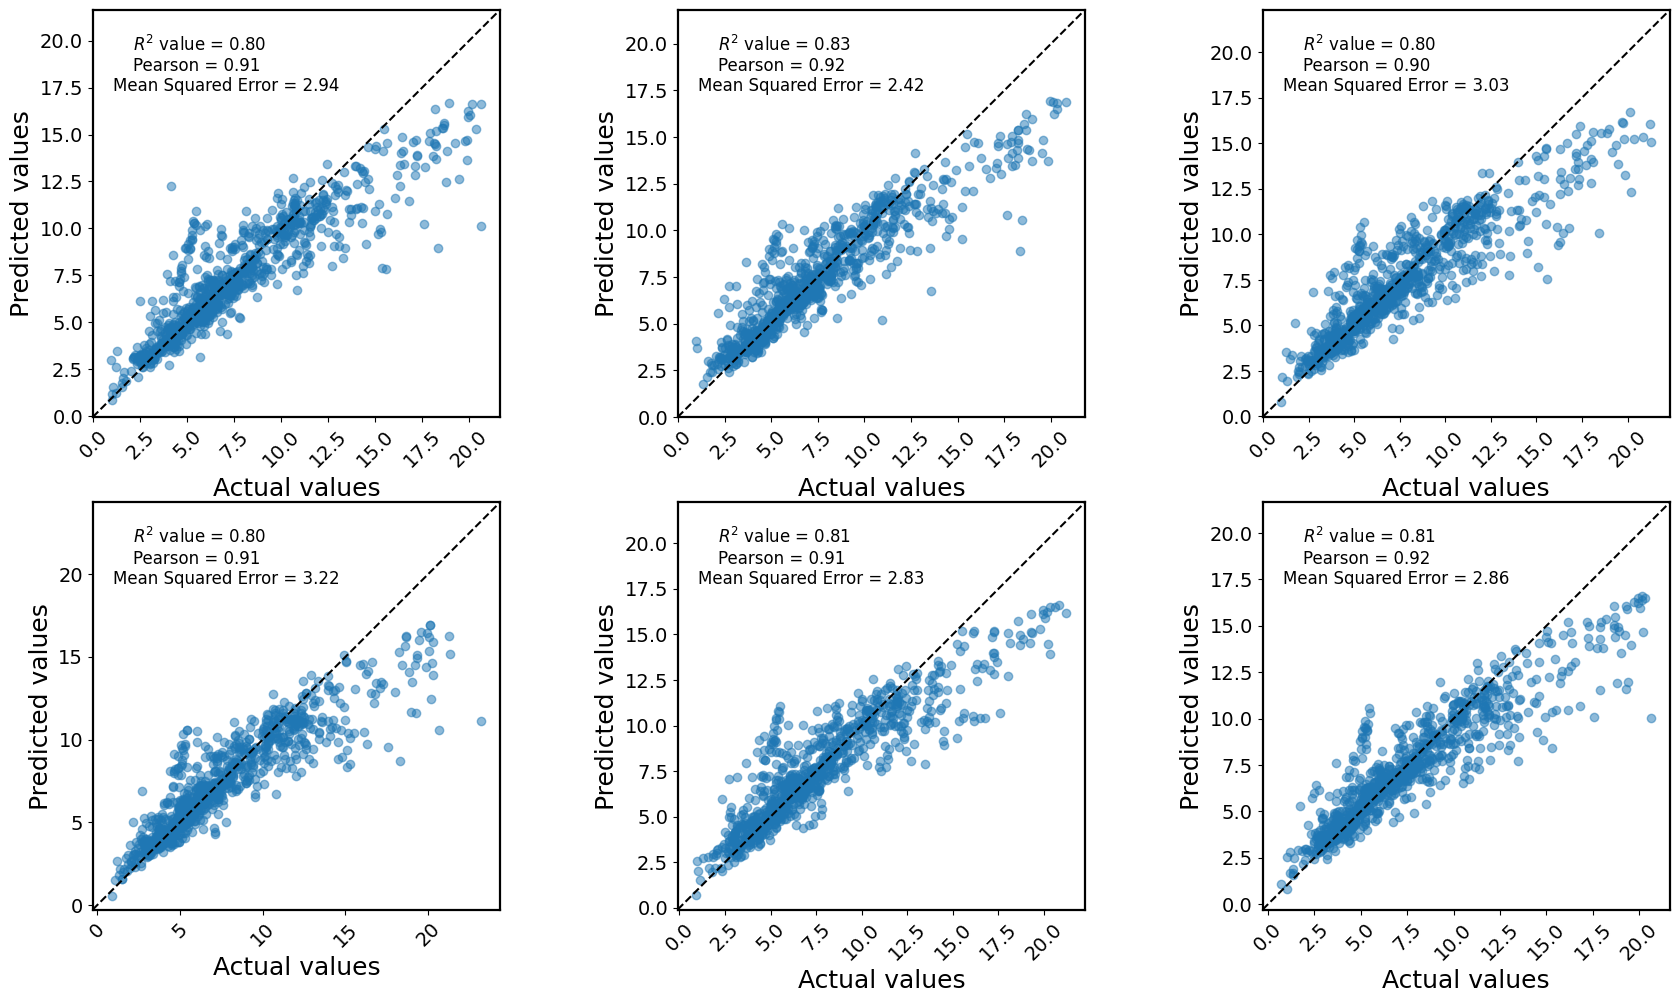

In [50]:
%%time
fig, axs = plt.subplots(nrows=2,ncols=3,figsize=(18,10))
n = 6
for i,ax in zip(range(n),axs.ravel()):
    features= np.array(X)
    labels = np.array(y)
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = i)    
    rf = chosen_model
    rf.fit(train_features, train_labels);
    predictions = rf.predict(test_features)
    errors = predictions - test_labels
    
    #Generate plot
    
    true_val,pred_val = test_labels,predictions
    ax.scatter(true_val,pred_val,alpha=0.5)
    
    
    
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]
    
    ax.text(0.1,
                       0.9,f'$R^2$ value = {format(r2_score(true_val,pred_val),"0.2f")}',
                       transform=ax.transAxes,fontsize=12)
    
    ax.text(0.1,
                       0.85,f'Pearson = {format(pearsonr(true_val,pred_val)[0],"0.2f")}',
                       transform=ax.transAxes,fontsize=12)
    ax.text(0.05,
                       0.8,f'Mean Squared Error = {round(mean_squared_error(true_val,pred_val),2)}',
                       transform=ax.transAxes,fontsize=12)
    
    
    # now plot both limits against eachother
    ax.plot(lims, lims, 'k--', alpha=1, zorder=1)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    
    plt.setp(ax.get_xticklabels(),fontsize=14,rotation=45)
    plt.setp(ax.get_yticklabels(),fontsize=14)
    ax.set_xlabel('Actual values',fontsize=18)
    ax.set_ylabel('Predicted values',fontsize=18)
    
    for i in ['top', 'left', 'right', 'bottom']:
            ax.spines[i].set_linewidth(1.6)
    del true_val, pred_val

plt.tight_layout()

In [51]:
del chosen_model, labels, features, train_features, test_features, train_labels, test_labels, rf, predictions, errors

# 3. Combine the three above models to form a stacked model, see how the stacked model performs on test data

In [52]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 42)

In [53]:
# adapted from https://www.analyticsvidhya.com/blog/2020/10/how-to-use-stacking-to-choose-the-best-possible-algorithm/
from sklearn.ensemble import StackingRegressor
import time
import math
GB_model = GradientBoostingRegressor(n_estimators = 1000, random_state = 42)
svr_model = SVR(kernel='rbf')
RF_model = RandomForestRegressor(n_estimators=1000,random_state=42)

estimators = [('Random Forest', RF_model),
              ('Support Vector Regressor', svr_model),
              ('Gradient Boosting', GB_model)]

#Stack these models with StackingRegressor
stacking_regressor = StackingRegressor(estimators=estimators,
                                       final_estimator=RidgeCV())

In [54]:
def plot_regression_results(ax, y_true, y_pred, title, scores, elapsed_time):
    """Scatter plot of predicted vs true."""
    ax.plot([y_true.min(), y_true.max()],
            [y_true.min(), y_true.max()],
            '--r', linewidth=2)
    ax.scatter(y_true, y_pred, alpha=0.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.get_xaxis().tick_bottom()
    ax.get_yaxis().tick_left()
    ax.spines['left'].set_position(('outward', 10))
    ax.spines['bottom'].set_position(('outward', 10))
    ax.set_xlim([y_true.min(), y_true.max()])
    ax.set_ylim([y_true.min(), y_true.max()])
    ax.set_xlabel('Actual')
    ax.set_ylabel('Predicted')
    extra = plt.Rectangle((0, 0), 0, 0, fc="w", fill=False,
                          edgecolor='none', linewidth=0)
    ax.legend([extra], [scores], loc='upper left')
    title = title + '({:.2f} seconds)'.format(elapsed_time)
    ax.set_title(title)


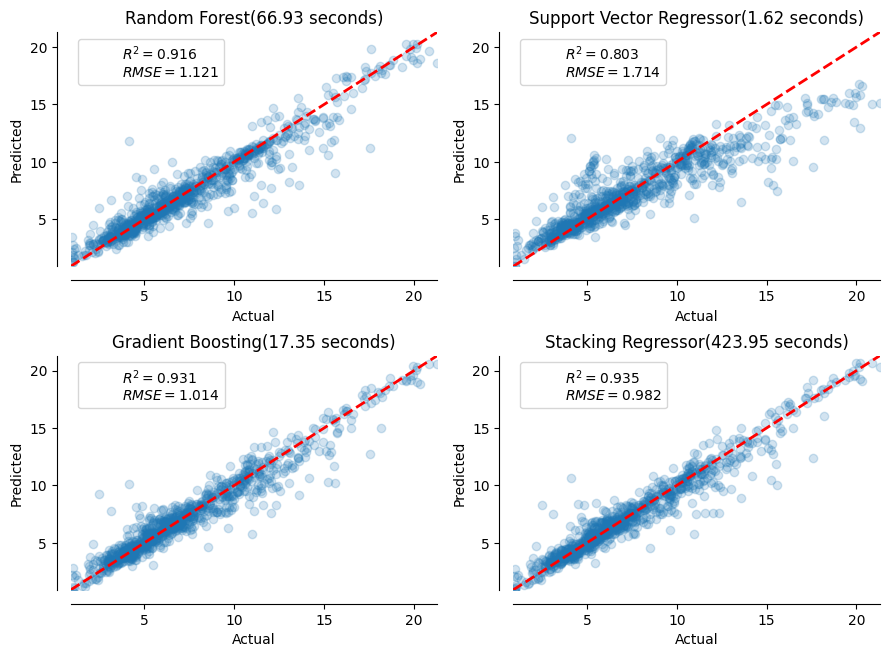

CPU times: user 8min 34s, sys: 2.73 s, total: 8min 36s
Wall time: 8min 35s


In [55]:
%%time
fig, axs = plt.subplots(2, 2, figsize=(9, 7))
axs = np.ravel(axs)
errors_list=[]
for ax, (name, est) in zip(axs, estimators + [('Stacking Regressor',
                                               stacking_regressor)]):
    start_time = time.time()
    model = est.fit(X_train, y_train)
                     
    elapsed_time = time.time() - start_time
    
    pred = model.predict(X_test)
    errors = y_test - model.predict(X_test)
    errors_list.append(errors)
    test_r2= r2_score(y_test, pred)
    
    test_rmsle=math.sqrt(mean_squared_error(y_test,pred))
    plot_regression_results(ax,y_test,pred,name,(r'$R^2={:.3f}$' + '\n' + 
                            r'$RMSE={:.3f}$').format(test_r2,test_rmsle),elapsed_time)
plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

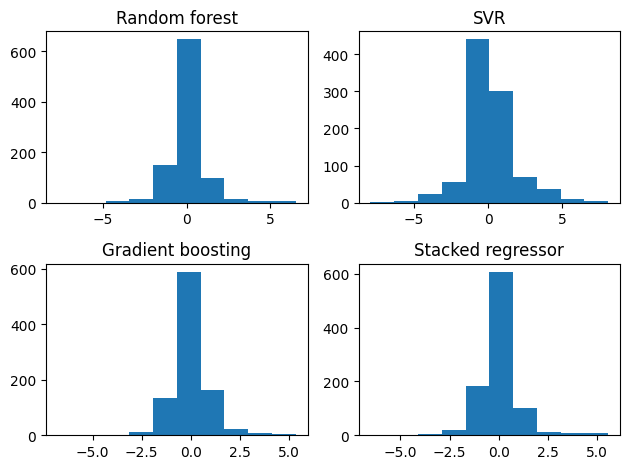

In [56]:
titles = ['Random forest','SVR','Gradient boosting','Stacked regressor'] 
f,a = plt.subplots(2,2)
a = a.ravel()
for idx,ax in enumerate(a):
    ax.hist(errors_list[idx])
    ax.set_title(titles[idx])
plt.tight_layout()

In [57]:
del X_train, X_test, y_train, y_test, GB_model, svr_model, RF_model, errors_list, pred, test_rmsle, training_df_ECFP, model

# 4. Get final prediction for _test.csv_ file provided

## a. train Random Forest Regressor model on entire training data

In [58]:
entire_labels = np.array(y)
entire_features= np.array(X)

In [59]:
del X, y

In [60]:

chosen_model=RandomForestRegressor(n_estimators = 1000, random_state = 42)
final_data_rf = chosen_model

final_data_rf.fit(entire_features, entire_labels);


## b. load and pre-process the _test.csv_ datafile provided


In [61]:
#load the train.csv data provided
test_df = pd.read_csv('test.csv')
test_df

,SMILES,Lab
0,CCC(=O)n1cc2c3c(cccc31)C1=CC(C(=O)N(CC)CC)CN(C...,Aarhus
1,CNC(C)C(=O)c1ccccc1Cl,Aarhus
2,CNC(C)C(=O)c1ccccc1C,Aarhus
3,CCCC(=O)N1CCN(CC=Cc2ccccc2)CC1C,Aarhus
4,COc1cc(CCNCc2ccccc2OC)c(OC)cc1Br,Aarhus
...,...,...
939,COC(=O)C(c1ccc(F)cc1)C1CCCCN1,Zurich Institute of Forensic Medicine
940,CN1CCN(C=C2N=C3CN=C(c4ccccc4Cl)c4cc([N+](=O)[O...,Zurich Institute of Forensic Medicine
941,COC(=O)C(NC(=O)c1cn(CCCCCF)c2ccccc12)C(C)C,Zurich Institute of Forensic Medicine
942,CNC(C)C(=O)c1ccc2c(c1)OCO2,Zurich Institute of Forensic Medicine


## c. Compute Extended Connectivity Fingerprint (ECFP)

In [62]:
feature_space = np.zeros(shape=(test_df.shape[0],1024))
j=0
for smilestring in test_df['SMILES'].values:
    ecfp_val=ECFP_from_smiles(smilestring,
                     R = 2,
                     L = 2**10,
                     use_features = False,
                     use_chirality = False)
    feature_space[j] = ecfp_val
    j+=1
test_df_ECFP = pd.concat([test_df,pd.DataFrame(feature_space,columns=[f'feat_ECFP_{i}' for i in np.arange(0,feature_space.shape[1],1) ])],axis=1).copy()
test_df_ECFP

,SMILES,Lab,feat_ECFP_0,feat_ECFP_1,feat_ECFP_2,feat_ECFP_3,feat_ECFP_4,feat_ECFP_5,feat_ECFP_6,feat_ECFP_7,...,feat_ECFP_1014,feat_ECFP_1015,feat_ECFP_1016,feat_ECFP_1017,feat_ECFP_1018,feat_ECFP_1019,feat_ECFP_1020,feat_ECFP_1021,feat_ECFP_1022,feat_ECFP_1023
0,CCC(=O)n1cc2c3c(cccc31)C1=CC(C(=O)N(CC)CC)CN(C...,Aarhus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,CNC(C)C(=O)c1ccccc1Cl,Aarhus,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,CNC(C)C(=O)c1ccccc1C,Aarhus,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,CCCC(=O)N1CCN(CC=Cc2ccccc2)CC1C,Aarhus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
4,COc1cc(CCNCc2ccccc2OC)c(OC)cc1Br,Aarhus,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,COC(=O)C(c1ccc(F)cc1)C1CCCCN1,Zurich Institute of Forensic Medicine,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
940,CN1CCN(C=C2N=C3CN=C(c4ccccc4Cl)c4cc([N+](=O)[O...,Zurich Institute of Forensic Medicine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
941,COC(=O)C(NC(=O)c1cn(CCCCCF)c2ccccc12)C(C)C,Zurich Institute of Forensic Medicine,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
942,CNC(C)C(=O)c1ccc2c(c1)OCO2,Zurich Institute of Forensic Medicine,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## d. One-hot encode the categorical 'Lab' column

In [63]:
lab_onehotencoded = pd.get_dummies(test_df['Lab'],dtype='float').copy()
lab_onehotencoded

,Aarhus,Academy of Forensic Science,Adelaide,Australian Racing Forensic Laboratory,CFSRE,ChemCentre,Copenhagen,Estonian Forensic Science Institute,Finnish Customs Laboratory,Ghent University,...,Labor Krone,Mainz,Odense,San Francisco OCME,The University of Queensland,Trondheim,University Hospital of Northern Norway,University of Athens,Victorian Institute of Forensic Medicine,Zurich Institute of Forensic Medicine
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
939,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
940,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
941,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
942,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## e. Get the features and perform Random Forest Regressor Prediction

In [64]:
X_for_testing = pd.concat([lab_onehotencoded,test_df_ECFP[test_df_ECFP.columns[test_df_ECFP.columns.str.contains('feat')].to_list()]],axis=1)

In [65]:
X_for_testing[X_for_testing.isnull()].sum().sum()

0.0

In [66]:
del test_df,lab_onehotencoded

In [67]:

final_predictions = final_data_rf.predict(X_for_testing)


/home/hshadman/.local/lib/python3.12/site-packages/sklearn/base.py:486: UserWarning: X has feature names, but RandomForestRegressor was fitted without feature names
  warnings.warn(


In [68]:
final_predictions

array([ 5.401884  ,  3.2473105 ,  3.3719285 ,  5.653934  ,  6.647249  ,
        3.19436   ,  3.213604  ,  4.321006  ,  4.029415  ,  3.49246   ,
        3.756425  ,  5.479036  ,  7.6766    ,  4.734143  ,  5.350724  ,
        7.726452  ,  7.64978   ,  7.488896  ,  7.473466  ,  9.596683  ,
        9.578792  ,  7.36553   ,  6.301291  ,  9.141343  ,  5.093637  ,
        8.753927  ,  5.479787  ,  5.23789   ,  6.358551  ,  9.237264  ,
        3.697972  ,  5.510894  ,  5.24251   ,  5.24379   ,  7.32814686,
        6.589618  ,  5.363966  ,  4.2911945 ,  4.334601  ,  4.281493  ,
        5.10726133,  7.79155   ,  5.002864  ,  5.054491  ,  3.57628767,
        8.34774   , 12.83488   ,  6.79063   ,  7.65401667,  9.41737   ,
        7.258672  ,  5.98545   ,  6.64794   ,  6.59533483,  9.09784   ,
        8.601828  ,  8.152775  ,  6.13202   , 12.11251733,  7.14253   ,
        7.23756417,  5.52292   ,  9.771014  ,  6.43496   ,  9.611005  ,
        5.15556   ,  7.56176   ,  6.084296  ,  7.70695   , 13.56

In [69]:

df_for_submission = pd.read_csv('test.csv')
df_for_submission['RT'] = final_predictions

In [70]:
df_for_submission

,SMILES,Lab,RT
0,CCC(=O)n1cc2c3c(cccc31)C1=CC(C(=O)N(CC)CC)CN(C...,Aarhus,5.401884
1,CNC(C)C(=O)c1ccccc1Cl,Aarhus,3.247310
2,CNC(C)C(=O)c1ccccc1C,Aarhus,3.371928
3,CCCC(=O)N1CCN(CC=Cc2ccccc2)CC1C,Aarhus,5.653934
4,COc1cc(CCNCc2ccccc2OC)c(OC)cc1Br,Aarhus,6.647249
...,...,...,...
939,COC(=O)C(c1ccc(F)cc1)C1CCCCN1,Zurich Institute of Forensic Medicine,4.754564
940,CN1CCN(C=C2N=C3CN=C(c4ccccc4Cl)c4cc([N+](=O)[O...,Zurich Institute of Forensic Medicine,7.888804
941,COC(=O)C(NC(=O)c1cn(CCCCCF)c2ccccc12)C(C)C,Zurich Institute of Forensic Medicine,10.461410
942,CNC(C)C(=O)c1ccc2c(c1)OCO2,Zurich Institute of Forensic Medicine,2.977232


In [71]:
df_for_submission.to_csv('final_results.csv',index=False)